In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Activation, Flatten, Input, concatenate, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Bidirectional, GRU


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Text preprocessing function

str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text  

In [4]:
# Read dataset & Preprocess text


df_train = pd.read_csv('gdrive/My Drive/Colab Notebooks/EmoTex/Data/weights/v1.2/Dataset/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('gdrive/My Drive/Colab Notebooks/EmoTex/Data/weights/v1.2/Dataset/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('gdrive/My Drive/Colab Notebooks/EmoTex/Data/weights/v1.2/Dataset/test.txt', names=['Text', 'Emotion'], sep=';')

df_test = df_test[df_test['Emotion'].isin(['sadness','anger','joy','fear'])]
df_val = df_val[df_val['Emotion'].isin(['sadness','anger','joy','fear'])]
df_train = df_train[df_train['Emotion'].isin(['sadness','anger','joy','fear'])]

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']


X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

In [5]:
# Encode labels

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [6]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))


sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 14980


In [7]:
# Embedding
max_features = vocabSize
maxlen = X_train.shape[1]
embedding_size = 200

# Convolution
kernel_size = 5
filters = 128
pool_size = 4

# GRU
gru_output_size = 128

# Training
#batch_size = 30
#epochs = 2

In [14]:
model = Sequential()
model.add(Embedding(vocabSize, embedding_size, input_length=X_train.shape[1]))
model.add(Dropout(0.3))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(Bidirectional(GRU(gru_output_size)))
model.add(Dense(4))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 256, 200)          2996000   
                                                                 
 dropout_2 (Dropout)         (None, 256, 200)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 252, 128)          128128    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 63, 128)          0         
 1D)                                                             
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              198144    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 4)                

In [15]:
adam = Adam(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [16]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

In [17]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=30,
                    callbacks=[callback]
                   )

Epoch 1/30
56/56 [==============================] - 107s 2s/step - loss: 0.7738 - accuracy: 0.6640 - val_loss: 0.3043 - val_accuracy: 0.9024
Epoch 2/30
56/56 [==============================] - 100s 2s/step - loss: 0.1333 - accuracy: 0.9552 - val_loss: 0.1108 - val_accuracy: 0.9586
Epoch 3/30
56/56 [==============================] - 100s 2s/step - loss: 0.0461 - accuracy: 0.9820 - val_loss: 0.1117 - val_accuracy: 0.9581
Epoch 4/30
56/56 [==============================] - 100s 2s/step - loss: 0.0254 - accuracy: 0.9911 - val_loss: 0.1331 - val_accuracy: 0.9575
Epoch 5/30
56/56 [==============================] - 99s 2s/step - loss: 0.0179 - accuracy: 0.9942 - val_loss: 0.1370 - val_accuracy: 0.9563


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


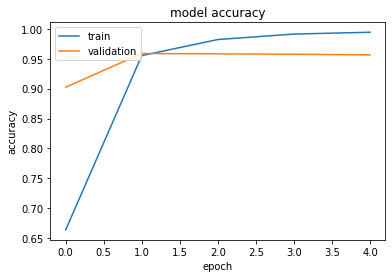

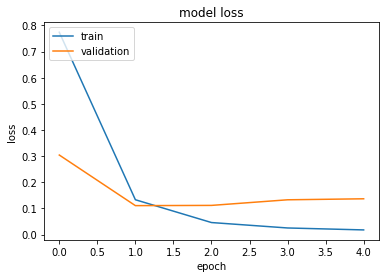

In [18]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [19]:
y_pred=np.argmax(model.predict(X_test), axis=-1)
print(y_pred)

[3 3 3 ... 2 2 1]


In [20]:
model.evaluate(X_test, y_test, verbose=1)

56/56 [==============================] - 4s 64ms/step - loss: 0.1028 - accuracy: 0.9600


[0.10275194048881531, 0.9599999785423279]

In [21]:
rounded_y_test = np.argmax(y_test, axis=1)

In [22]:
print(accuracy_score(rounded_y_test, y_pred))

0.96


In [23]:
#Classification report
print(classification_report(rounded_y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.90714   0.92364   0.91532       275
           1    0.92793   0.91964   0.92377       224
           2    0.97599   0.99424   0.98503       695
           3    0.97876   0.95181   0.96510       581

    accuracy                        0.96000      1775
   macro avg    0.94746   0.94733   0.94730      1775
weighted avg    0.96016   0.96000   0.95997      1775



Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)


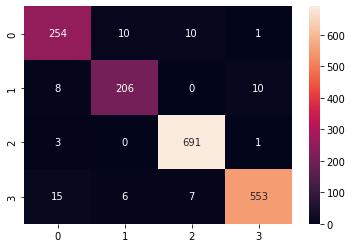

In [24]:
print('Confusion Matrix')
print(sns.heatmap(confusion_matrix(rounded_y_test, y_pred),annot=True,fmt="d"))

In [ ]:
# Classify custom sample
def predict(sentence):
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

In [ ]:
predict('My friend scared the hell out me')

My friend scared the hell out me
fear : 0.7884963750839233




In [ ]:
import pickle
with open('gdrive/My Drive/Colab Notebooks/EmoTex/Data/weights/v1.2/pickle/tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('gdrive/My Drive/Colab Notebooks/EmoTex/Data/weights/v1.2/pickle/labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)

In [ ]:
model.save('gdrive/My Drive/Colab Notebooks/EmoTex/Data/weights/v1.2/saved model')

INFO:tensorflow:Assets written to: gdrive/My Drive/Colab Notebooks/EmoTex/Data/weights/v1.2/saved model/assets


INFO:tensorflow:Assets written to: gdrive/My Drive/Colab Notebooks/EmoTex/Data/weights/v1.2/saved model/assets


In [ ]:
predict('Today I broke my arm')

Today I broke my arm
sadness : 0.9953283071517944


